In [1]:
### Loading Required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline

### defining palette of colors
col_list = ['#005f9a', '#00CDCD', '#f1bdbf']
sns.set_palette(col_list)

In [2]:
### Importing dataset
credit_df = pd.read_csv('student_credit_dataset.csv')

#### Analisis Exploratorio

In [3]:
df_texto = credit_df.select_dtypes(include=['object'])
df_numerico = credit_df.select_dtypes(include=['number'])

In [4]:
descriptivas_numericas = credit_df.describe(include='all')

tabla_descriptivas = pd.DataFrame({
    'Variable': descriptivas_numericas.columns,
    'Media': descriptivas_numericas.loc['mean'],
    'Mediana': descriptivas_numericas.loc['50%'],
    'Moda': df_numerico.mode().iloc[0]
})

print(tabla_descriptivas)

            Variable      Media  Mediana     Moda
age           income    55.6675     56.0   44.000
balance      balance    520.015    459.5    0.000
cards          limit     2.9575      3.0    2.000
education     rating      13.45     14.0   16.000
ethnicity      cards        NaN      NaN      NaN
gender           age        NaN      NaN      NaN
income     education  45.218885  33.1155   23.793
limit         gender     4735.6   4622.5  855.000
married      student        NaN      NaN      NaN
rating       married     354.94    344.0  344.000
student    ethnicity        NaN      NaN      NaN


In [5]:
# Medidas de dispersion
# Calcular las estadisticas desprictivas para las medidas de dispersión
varianza = df_numerico.var()
desviacion_estandar = df_numerico.std()
rango = df_numerico.max() - df_numerico.min()
iqr = df_numerico.quantile(0.75) - df_numerico.quantile(0.25)

# Hacer un dataframe para las medidas de dispersion
tabla_dispersion = pd.DataFrame({
    'Variable': df_numerico.columns,
    'Varianza': varianza,
    'Desviación Estándar': desviacion_estandar,
    'Rango': rango,
    'IQR': iqr
})

print(tabla_dispersion)


            Variable      Varianza  Desviación Estándar     Rango        IQR
income        income  1.242159e+03            35.244273    176.28    36.4635
balance      balance  2.113782e+05           459.758877   1999.00   794.2500
limit          limit  5.327782e+06          2308.198848  13058.00  2784.7500
rating        rating  2.393956e+04           154.724143    889.00   190.0000
cards          cards  1.880395e+00             1.371275      8.00     2.0000
age              age  2.975558e+02            17.249807     75.00    28.2500
education  education  9.766917e+00             3.125207     15.00     5.0000


In [6]:
# Medidas de posición
# Cuartiles
q1 = df_numerico.quantile(0.25)
q2 = df_numerico.quantile(0.50)  # Esto es igual a la mediana
q3 = df_numerico.quantile(0.75)

# Deciles
deciles = {f'Decil_{i}': df_numerico.quantile(i / 10) for i in range(1, 10)}

# Percentiles (calculando específicamente el 10%, 20%, ..., 90%)
percentiles = {f'Percentil_{i}': df_numerico.quantile(i / 100) for i in range(10, 100, 10)}

# Crear un DataFrame para cuartiles, deciles y percentiles
tabla_posicion = pd.DataFrame({
    'Variable': df_numerico.columns,
    'Cuartil_1': q1,
    'Cuartil_2 (Mediana)': q2,
    'Cuartil_3': q3,
})

# Añadir deciles y percentiles al DataFrame
for nombre, valor in deciles.items():
    tabla_posicion[nombre] = valor

for nombre, valor in percentiles.items():
    tabla_posicion[nombre] = valor

print(tabla_posicion)


            Variable   Cuartil_1  Cuartil_2 (Mediana)   Cuartil_3    Decil_1  \
income        income    21.00725              33.1155    57.47075    14.5834   
balance      balance    68.75000             459.5000   863.00000     0.0000   
limit          limit  3088.00000            4622.5000  5872.75000  1918.6000   
rating        rating   247.25000             344.0000   437.25000   167.0000   
cards          cards     2.00000               3.0000     4.00000     1.0000   
age              age    41.75000              56.0000    70.00000    32.0000   
education  education    11.00000              14.0000    16.00000     9.0000   

             Decil_2    Decil_3    Decil_4    Decil_5    Decil_6  ...  \
income       19.2088    23.7567    27.8126    33.1155    40.0754  ...   
balance       0.0000   142.9000   300.4000   459.5000   606.4000  ...   
limit      2745.0000  3343.8000  3916.0000  4622.5000  5108.2000  ...   
rating      216.6000   263.7000   299.0000   344.0000   377.0000  .

In [7]:
# Medidas de forma
# Asimetría
asimetria = df_numerico.skew()

# Curtosis
curtosis = df_numerico.kurt()

# Crear un DataFrame para las medidas de forma
tabla_forma = pd.DataFrame({
    'Variable': df_numerico.columns,
    'Asimetría': asimetria,
    'Curtosis': curtosis
})

print(tabla_forma)


            Variable  Asimetría  Curtosis
income        income   1.742117  2.947476
balance      balance   0.584595 -0.527858
limit          limit   0.837493  1.004247
rating        rating   0.865394  1.060947
cards          cards   0.791928  0.943953
age              age   0.011496 -1.065580
education  education  -0.329212 -0.578121


In [8]:
# Tablas de frecuencia


if 'categoria' in df_numerico.columns:
    tabla_frecuencia = df_numerico['categoria'].value_counts().reset_index()
    tabla_frecuencia.columns = ['Valor', 'Frecuencia']
    tabla_frecuencia['Frecuencia Relativa'] = tabla_frecuencia['Frecuencia'] / len(df_numerico)

    print(tabla_frecuencia)
else:
    print("No se encontró una columna categórica llamada 'categoria'.")

# Si quieres hacerlo para múltiples columnas categóricas o discretas:
tablas_frecuencia = {}
for col in df_numerico.columns:
    if df_numerico[col].dtype == 'object' or df_numerico[col].nunique() < 10:  # Para variables categóricas o discretas
        frecuencia = df_numerico[col].value_counts().reset_index()
        frecuencia.columns = [f'{col}_Valor', 'Frecuencia']
        frecuencia['Frecuencia Relativa'] = frecuencia['Frecuencia'] / len(df_numerico)
        tablas_frecuencia[col] = frecuencia

# Imprimir todas las tablas de frecuencia
for col, tabla in tablas_frecuencia.items():
    print(f"\nTabla de Frecuencia para {col}:\n", tabla)


No se encontró una columna categórica llamada 'categoria'.

Tabla de Frecuencia para cards:
    cards_Valor  Frecuencia  Frecuencia Relativa
0            2         115               0.2875
1            3         111               0.2775
2            4          72               0.1800
3            1          51               0.1275
4            5          34               0.0850
5            6          11               0.0275
6            7           4               0.0100
7            8           1               0.0025
8            9           1               0.0025


In [9]:
# Medidas de posición y tablas de frecuencia para las variables categóricas
categorical_columns = ['gender', 'student', 'married', 'ethnicity', 'cards']

# Diccionario para almacenar las tablas de frecuencia
tablas_frecuencia = {}

# Generar tablas de frecuencia para cada variable categórica
for col in categorical_columns:
    if col in df_numerico.columns:
        tabla_frecuencia = df_numerico[col].value_counts().reset_index()
        tabla_frecuencia.columns = [f'{col}_Valor', 'Frecuencia']
        tabla_frecuencia['Frecuencia Relativa'] = tabla_frecuencia['Frecuencia'] / len(df_numerico)
        tablas_frecuencia[col] = tabla_frecuencia

# Imprimir todas las tablas de frecuencia
for col, tabla in tablas_frecuencia.items():
    print(f"\nTabla de Frecuencia para {col}:\n", tabla)



Tabla de Frecuencia para cards:
    cards_Valor  Frecuencia  Frecuencia Relativa
0            2         115               0.2875
1            3         111               0.2775
2            4          72               0.1800
3            1          51               0.1275
4            5          34               0.0850
5            6          11               0.0275
6            7           4               0.0100
7            8           1               0.0025
8            9           1               0.0025


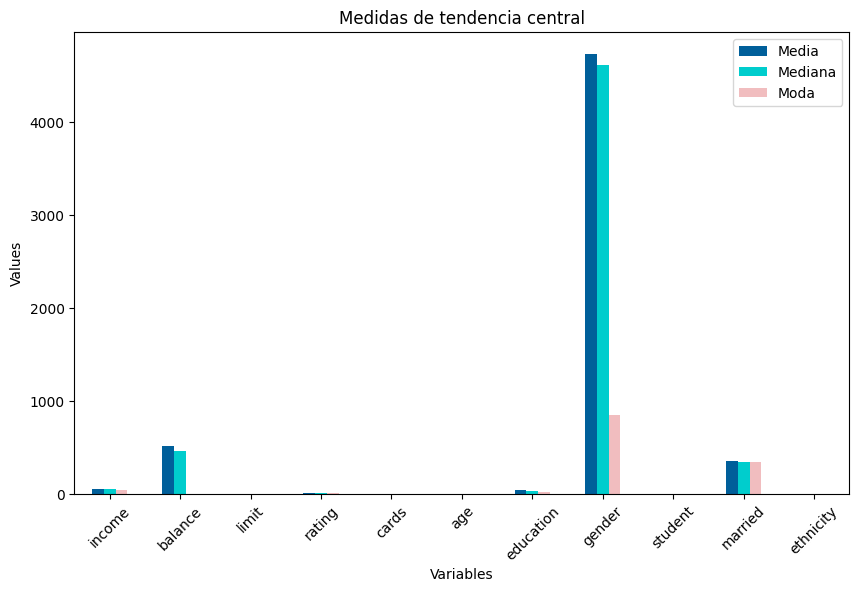

In [10]:
import matplotlib.pyplot as plt

# Bar plot para medidas de tendencia central
tabla_descriptivas.set_index('Variable', inplace=True)
tabla_descriptivas[['Media', 'Mediana', 'Moda']].plot(kind='bar', figsize=(10, 6))
plt.title('Medidas de tendencia central')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


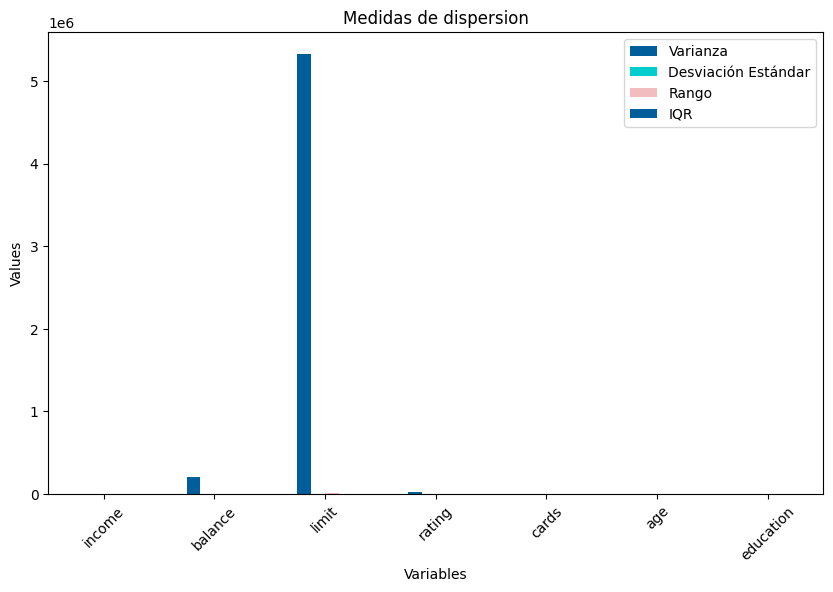

In [11]:
# box plot medidas de sipersion
tabla_dispersion.set_index('Variable', inplace=True)
tabla_dispersion[['Varianza', 'Desviación Estándar', 'Rango', 'IQR']].plot(kind='bar', figsize=(10, 6))
plt.title('Medidas de dispersion')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()


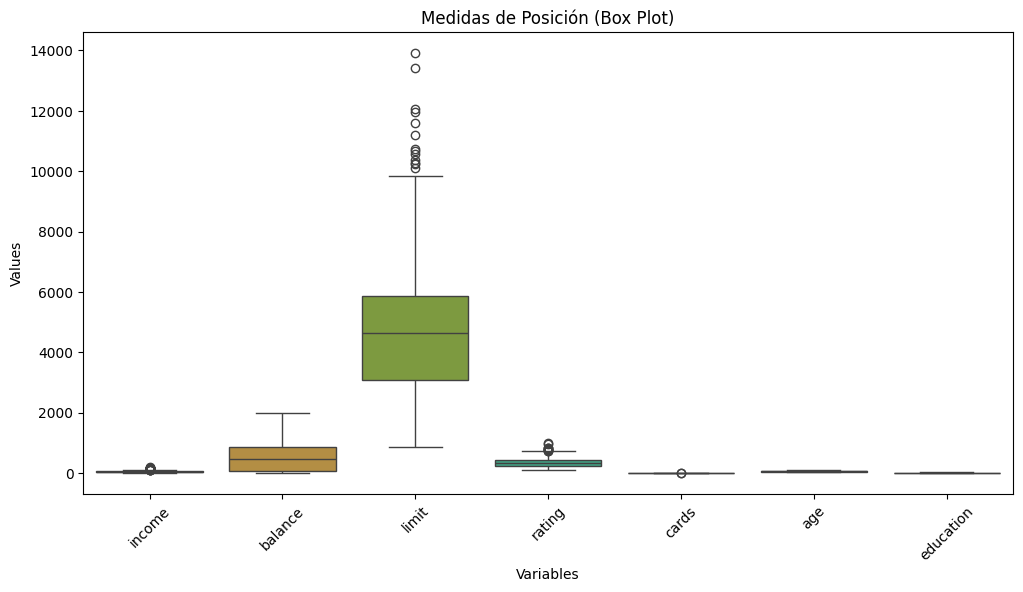

In [12]:


# Box plot para medidas de posicion
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_numerico)
plt.title('Medidas de Posición (Box Plot)')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.show()


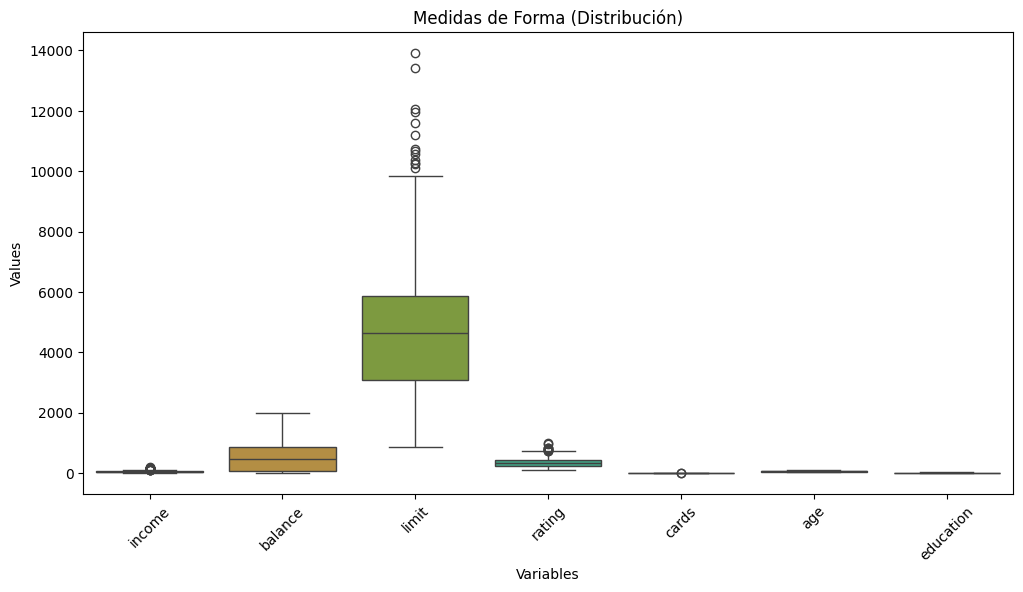

In [13]:
# Box plot para medidas de forma
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_numerico)
plt.title('Medidas de Forma (Distribución)')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.show()


In [14]:
# Calcular el correlation matrix
correlation_matrix = df_numerico.corr()

print(correlation_matrix)


             income   balance     limit    rating     cards       age  \
income     1.000000  0.463656  0.792088  0.791378 -0.018273  0.175338   
balance    0.463656  1.000000  0.861697  0.863625  0.086456  0.001835   
limit      0.792088  0.861697  1.000000  0.996880  0.010231  0.100888   
rating     0.791378  0.863625  0.996880  1.000000  0.053239  0.103165   
cards     -0.018273  0.086456  0.010231  0.053239  1.000000  0.042948   
age        0.175338  0.001835  0.100888  0.103165  0.042948  1.000000   
education -0.027692 -0.008062 -0.023549 -0.030136 -0.051084  0.003619   

           education  
income     -0.027692  
balance    -0.008062  
limit      -0.023549  
rating     -0.030136  
cards      -0.051084  
age         0.003619  
education   1.000000  


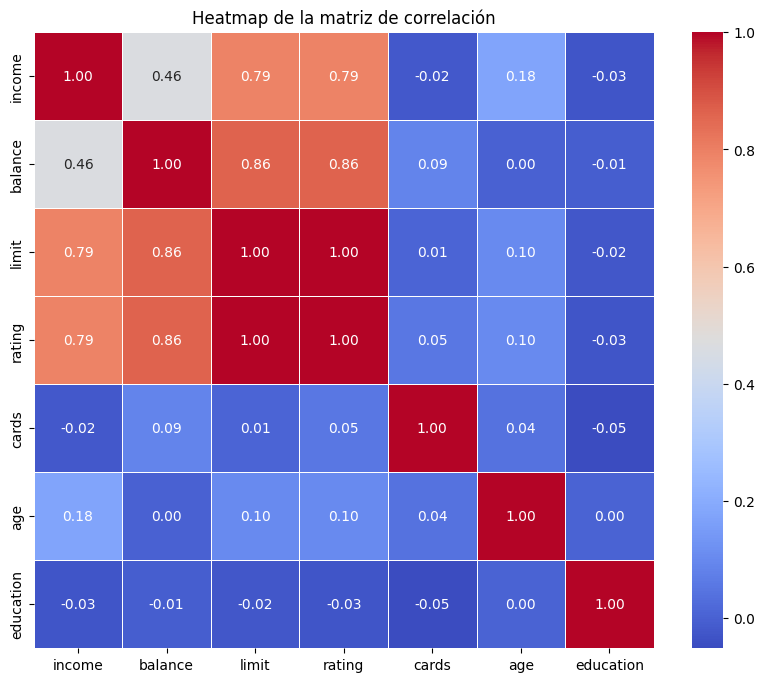

In [15]:
plt.figure(figsize=(10, 8))

# Hacer heatmap del correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Heatmap de la matriz de correlación')
plt.show()

#### Modelo de regresion lineal

In [16]:
### Transforming categorical variables as a factor
credit_df.gender = credit_df.gender.astype('category')
credit_df.student = credit_df.student.astype('category')
credit_df.married = credit_df.married.astype('category')
credit_df.ethnicity = credit_df.ethnicity.astype('category')

In [17]:
### Lets define a categorical variable / dependent variable for logistic regression
credit_df['Active'] = np.where(credit_df['balance']>0, 'Yes', 'No')
credit_df.Active.describe()

,Active
count,400
unique,2
top,Yes
freq,310


In [18]:
### MODELO 1
### MLRM
independent_vars = 'income + rating + age + student'

lm_mod = smf.ols(f'balance ~ {independent_vars}', data=credit_df).fit()

print(lm_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     1892.
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          4.17e-256
Time:                        04:33:57   Log-Likelihood:                -2418.6
No. Observations:                 400   AIC:                             4847.
Df Residuals:                     395   BIC:                             4867.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -547.3047     21.461    -25.

Log-Linear Model

In [19]:
#Modelo 2
# Define the independent variables
independent_vars = 'np.log(income) + np.log(limit) + np.log(rating)+ cards + age + education + gender + student + married + ethnicity'
credit_df['log_balance'] = np.log(credit_df['balance'] + 1)

In [20]:
log_lm_mod = smf.ols(f'log_balance ~ np.log(income) + np.log(limit) + np.log(rating) + student', data=credit_df).fit()

# Output the summary of the model
print(log_lm_mod.summary())

log_OLS_pred = np.exp(log_lm_mod.predict(credit_df)) - 1

# Print a few of the predicted values
print(log_OLS_pred.head())

                            OLS Regression Results                            
Dep. Variable:            log_balance   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     480.6
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          2.84e-150
Time:                        04:33:57   Log-Likelihood:                -613.86
No. Observations:                 400   AIC:                             1238.
Df Residuals:                     395   BIC:                             1258.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -30.5864      1.486    -20.

In [21]:
# MODELO 3
### Polynomial Regression Model
# Definir independent variables(features) y dependent variable (target)
X = credit_df[['income', 'rating','cards','age','education']]
y = credit_df['balance']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert the polynomial features to a DataFrame for better readability
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))


In [22]:
X_poly_with_constant = sm.add_constant(X_poly_df)


In [23]:
# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Make predictions
y_pred = model.predict(X_poly)

# Calculate performance metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print the model performance
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 21255.352367011958
R-squared (R2): 0.8991919631611958


In [24]:
# coeficientes del modelo de regresion polinomial
print("Coefficients:")
print(pd.Series(model.coef_, index=poly.get_feature_names_out(X.columns)))

# Intercepto
print(f"Intercept: {model.intercept_}")


Coefficients:
income              -1.789090
rating               1.146446
cards               43.415071
age                  7.869924
education           15.291237
income^2             0.056042
income rating       -0.039022
income cards         0.043241
income age           0.049129
income education    -0.003547
rating^2             0.006901
rating cards        -0.009012
rating age          -0.010096
rating education     0.018574
cards^2              1.644660
cards age           -0.421736
cards education     -2.456882
age^2               -0.061048
age education        0.033528
education^2         -0.518484
dtype: float64
Intercept: -580.5388187644452


In [25]:
# Fit the polynomial regression model
model = sm.OLS(y, X_poly_with_constant).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     169.0
Date:                Fri, 30 Aug 2024   Prob (F-statistic):          6.16e-175
Time:                        04:33:57   Log-Likelihood:                -2560.4
No. Observations:                 400   AIC:                             5163.
Df Residuals:                     379   BIC:                             5247.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -580.5388    225.173  

In [26]:
# MODELO 1 VIF
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Create a DataFrame with only the independent variables
X = credit_df[['income', 'limit', 'rating', 'cards', 'age']]

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


  Variable         VIF
0    const   25.227979
1   income    2.772743
2    limit  227.842810
3   rating  229.587822
4    cards    1.433859
5      age    1.038413


In [27]:
# VIF MODELO 2
# Apply the log transformations
credit_df['log_income'] = np.log(credit_df['income'])
credit_df['log_limit'] = np.log(credit_df['limit'])
credit_df['log_rating'] = np.log(credit_df['rating'])

# Create a DataFrame with the independent variables
X = credit_df[['log_income', 'log_limit', 'log_rating', 'cards', 'age', 'education' ]]

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Add a constant to the model (for the intercept)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF for each feature:")
print(vif_data)


VIF for each feature:
     Variable         VIF
0       const  834.621683
1  log_income    1.899601
2   log_limit   73.991318
3  log_rating   77.150761
4       cards    1.219892
5         age    1.035951
6   education    1.007250


In [28]:
# VIF MODELO 3
vif_data = pd.DataFrame()
vif_data['Feature'] = X_poly_df.columns
vif_data['VIF'] = [variance_inflation_factor(X_poly_df.values, i) for i in range(X_poly_df.shape[1])]

print("VIF for each feature:")
print(vif_data)

VIF for each feature:
             Feature         VIF
0             income  382.420657
1             rating  803.527232
2              cards  246.961572
3                age  589.759257
4          education  570.296734
5           income^2  160.487848
6      income rating  939.202614
7       income cards   51.280118
8         income age  109.353639
9   income education  143.754730
10          rating^2  618.641868
11      rating cards  129.840731
12        rating age  206.790927
13  rating education  314.897395
14           cards^2   27.853611
15         cards age   72.557568
16   cards education   97.427257
17             age^2  219.389251
18     age education  192.060632
19       education^2  260.481278


In [29]:
# MODELO 1
# Heterocedasticity - Log Regression Model
# Breusch - Pagan Lagrange Multiplier Test
# if the p-value < 5% then we might have the presence of heterocedascity
from statsmodels.compat import lzip
import statsmodels.api as sm
name_log = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_log = sm.stats.het_breuschpagan(lm_mod.resid, lm_mod.model.exog)
lzip(name_log, test_log)

[('Lagrange multiplier statistic', 85.29969639170352),
 ('p-value', 1.3103551267121803e-17),
 ('f-value', 26.766243699482263),
 ('f p-value', 1.154747298618737e-19)]

In [30]:
# MODELO 2
# Heterocedasticity - Log Regression Model
# Breusch - Pagan Lagrange Multiplier Test
# if the p-value < 5% then we might have the presence of heterocedascity
from statsmodels.compat import lzip
import statsmodels.api as sm
name_log = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_log = sm.stats.het_breuschpagan(log_lm_mod.resid, log_lm_mod.model.exog)
lzip(name_log, test_log)

[('Lagrange multiplier statistic', 56.7347703454776),
 ('p-value', 1.4062626196343251e-11),
 ('f-value', 16.32136927254351),
 ('f p-value', 2.2010486947860846e-12)]

In [31]:
# MODELO 3
# BREUSCH PAGAN TEST
name_bp = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_bp = sm.stats.het_breuschpagan(model.resid, model.model.exog)

print("Breusch-Pagan test results:")
print(lzip(name_bp, test_bp))

Breusch-Pagan test results:
[('Lagrange multiplier statistic', 30.870862494870764), ('p-value', 0.05691852805922333), ('f-value', 1.5848189287676375), ('f p-value', 0.053175519155752894)]


In [32]:
### MODELO 1
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(lm_mod.resid)
lzip(name, test)

[('Jarque-Bera', 17.00008438757724),
 ('Chi^2 two-tail prob.', 0.00020345978409040788),
 ('Skew', 0.49425895069331227),
 ('Kurtosis', 2.7930279683319075)]

In [33]:
### MODELO 2
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(log_lm_mod.resid)
lzip(name, test)

[('Jarque-Bera', 60.66927636367773),
 ('Chi^2 two-tail prob.', 6.696286507148787e-14),
 ('Skew', -0.8849460114954338),
 ('Kurtosis', 3.7124877604380004)]

In [34]:
### MODELO 3
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(model.resid)
lzip(name, test)

[('Jarque-Bera', 406.91538028219173),
 ('Chi^2 two-tail prob.', 4.359612317374761e-89),
 ('Skew', 1.789471374197733),
 ('Kurtosis', 6.40677143651273)]

In [35]:
### MODELO 1
# RMSE
# Make predictions using the fitted model

# Apply the log transformations directly to the DataFrame
credit_df['log_income'] = np.log(credit_df['income'])
credit_df['log_limit'] = np.log(credit_df['limit'])
credit_df['log_rating'] = np.log(credit_df['rating'])

# Re-define the independent variables based on the transformed columns
independent_vars = 'log_income + log_limit + log_rating + cards + age + student'

lm_mod = smf.ols(f'balance ~ {independent_vars}', data=credit_df).fit()

y_pred = lm_mod.predict(credit_df[['log_income', 'log_limit', 'log_rating', 'cards', 'age', 'student']])

rmse = np.sqrt(mean_squared_error(credit_df['balance'], y_pred))

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 186.27840243371077


In [36]:
 ### MODELO 2
 #RMSE

# Calculate RMSE between the predicted values and the actual balance values
rmse = np.sqrt(mean_squared_error(credit_df['balance'], log_OLS_pred))

print(f"Root Mean Square Error (RMSE): {rmse}")


Root Mean Square Error (RMSE): 1127.831075750308


In [37]:
 ### MODELO 3
 #RMSE
y_pred = model.predict(X_poly_with_constant)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 145.7921546826576


In [38]:
# MODELO 1 AIC
aic = lm_mod.aic

print(f"MODELO 3 AIC: {aic}")

MODELO 3 AIC: 5330.944700101076


In [39]:
# MODELO 2 AIC
aic = log_lm_mod.aic

print(f"MODELO 2 AIC: {aic}")

MODELO 2 AIC: 1237.7202793644176


In [40]:

#MODELO 3 AIC
aic = model.aic

print(f"MODELO 3 AIC: {aic}")

MODELO 3 AIC: 5162.896434056453


Regresion Logistica:

In [41]:
import numpy as np

# Crear la variable Credit_Default
credit_df['Credit_Default'] = np.where(credit_df['balance'] > 500, 1, 0)

In [50]:
import statsmodels.formula.api as smf

# Especificar el modelo base
logistic_mod = smf.glm(formula='Credit_Default ~ income + student + married',
                       data=credit_df,
                       family=sm.families.Binomial()).fit()

# Resumen del modelo
print(logistic_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Credit_Default   No. Observations:                  400
Model:                            GLM   Df Residuals:                      396
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -246.86
Date:                Fri, 30 Aug 2024   Deviance:                       493.72
Time:                        04:49:51   Pearson chi2:                     393.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1393
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2234      0.240     -5.

In [43]:
X = credit_df[['income', 'balance', 'limit', 'rating', 'cards', 'age', 'education',
               'gender', 'student', 'married', 'ethnicity']]
y = credit_df['Credit_Default']

X = pd.get_dummies(X, drop_first=True)

X = sm.add_constant(X)

print(X.dtypes)

X['gender_Female'] = X['gender_Female'].astype(int)
X['student_Yes'] = X['student_Yes'].astype(int)
X['married_Yes'] = X['married_Yes'].astype(int)
X['ethnicity_Asian'] = X['ethnicity_Asian'].astype(int)
X['ethnicity_Caucasian'] = X['ethnicity_Caucasian'].astype(int)

const                  float64
income                 float64
balance                  int64
limit                    int64
rating                   int64
cards                    int64
age                      int64
education                int64
gender_Female             bool
student_Yes               bool
married_Yes               bool
ethnicity_Asian           bool
ethnicity_Caucasian       bool
dtype: object


In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Variable         VIF
0                 const   76.709212
1                income   10.755482
2               balance   22.272490
3                 limit  254.487716
4                rating  239.106505
5                 cards    1.510935
6                   age    1.063226
7             education    1.020831
8         gender_Female    1.008843
9           student_Yes    2.754742
10          married_Yes    1.046463
11      ethnicity_Asian    1.557823
12  ethnicity_Caucasian    1.530202


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Assuming 'credit_df' is already defined

# Define independent variables (X) and dependent variable (y)
X = credit_df[['income', 'student', 'married', 'age', 'cards']]
y = credit_df['Credit_Default']

# Split the data into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Combine X_train and y_train to a training dataframe for use in the statsmodels formula API
train_df = pd.concat([X_train, y_train], axis=1)

# Fit the logistic regression model using the training data
logistic_mod = smf.glm(formula='Credit_Default ~ income + student + married + age + cards',
                       data=train_df,
                       family=sm.families.Binomial()).fit()

print(logistic_mod.summary())


X_test['pred_prob'] = logistic_mod.predict(X_test)
X_test['pred_class'] = (X_test['pred_prob'] >= 0.5).astype(int)

# Model's performance
accuracy = accuracy_score(y_test, X_test['pred_class'])
conf_matrix = confusion_matrix(y_test, X_test['pred_class'])

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:         Credit_Default   No. Observations:                  320
Model:                            GLM   Df Residuals:                      314
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -200.56
Date:                Fri, 30 Aug 2024   Deviance:                       401.12
Time:                        04:50:19   Pearson chi2:                     315.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1227
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0581      0.507     -2.

In [52]:
print(credit_df['Credit_Default'].value_counts())

Credit_Default
0    209
1    191
Name: count, dtype: int64


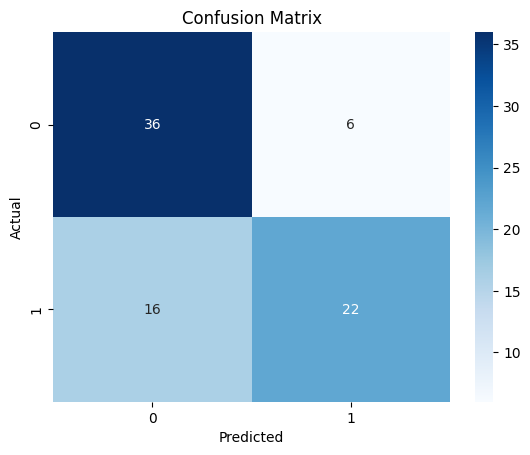

In [53]:
### Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
len(y_test.unique()) > 1
y_proba = logistic_mod.predict(X_test)

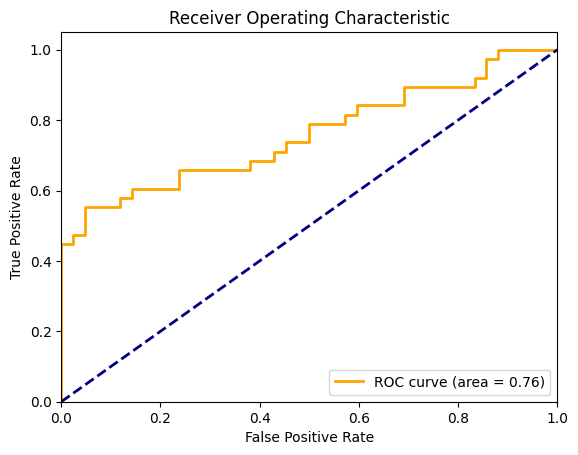

In [55]:
# ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

**Breve descripción de los principales hallazgos identificados a través del proceso de analítica
de datos de I – IV.**

En conclusion, despues de haber elegido el Modelo 2 como el mejor de los MLRM, Las variables student, income, rating y age son todas estadísticamente significativas, con p-valores muy bajos, lo que resalta su importancia en la predicción del balance. De esta manera, ser estudiante se asocia con un aumento significativo en el balance de 417 unidades, mientras que un mayor ingreso reduce el balance. Adicionalmente a esto, la variable rating también tiene un impacto positivo significativo, con un coeficiente de 3.98, lo que sugiere que un mayor rating está asociado con un mayor balance. La variable age tiene un efecto negativo moderado pero significativo en el balance. Adicionalmente a esto, el número de condición es 1.66e+03, lo que podría indicar cierta multicolinealidad, aunque despues de sacar los VIF se busco reducirla en su mayoria, como se puede apreciar el test de Jarque-Bera, que una ligera desviación de la normalidad, pero no lo suficientemente fuerte como para comprometer significativamente la validez del modelo.

Por otro lado, la Regresion Logistica, muestra que el estado de ser estudiante y el nivel de ingresos son predictores significativos del incumplimiento de crédito (Credit_Default). Específicamente, ser estudiante aumenta significativamente la probabilidad de incumplimiento, mientras que un incremento en el ingreso también está asociado con un mayor riesgo de incumplimiento. Por otro lado, variables como estar casado, la edad y el número de tarjetas no tienen un impacto estadísticamente significativo en la probabilidad de incumplimiento.

El modelo presenta un nivel de discriminación aceptable, con un AUC de 0.76 en la curva ROC, lo que indica que el modelo tiene una capacidad moderada para distinguir entre aquellos que incumplen y aquellos que no. Sin embargo, la matriz de confusión revela que el modelo tiene un número considerable de falsos negativos, lo que sugiere que hay margen de mejora, especialmente en la identificación de aquellos que incumplen.